# Example code for loading dicom images and subject information for EMC Hackathon 2024

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Load needed packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import numpy as np
import pandas as pd
import os
import skimage

## Define paths and input files

In [ ]:
#Load file containing training samples
main_dir = r"/mnt/bigr0006/data/"
train_filename = "training_set_full_with_na.csv"
img_folder = "train"


df_train = pd.read_csv(os.path.join(main_dir, train_filename))

#first few rows of dataset
df_train.head()


,dataset,subject_id,visit,hip_side,dicom_image,hip_oa_grade,age_baseline,bmi_baseline,sex_assigned_birth,set
0,CHECK,CHECK-01001,T02,left,CHECK-01001-T02-LH.dcm,0,46,26.0,Male,train
1,CHECK,CHECK-01001,T02,right,CHECK-01001-T02-RH.dcm,0,46,26.0,Male,train
2,CHECK,CHECK-01001,T05,left,CHECK-01001-T05-LH.dcm,0,46,26.0,Male,train
3,CHECK,CHECK-01001,T05,right,CHECK-01001-T05-RH.dcm,0,46,26.0,Male,train
4,CHECK,CHECK-01001,T08,left,CHECK-01001-T08-LH.dcm,0,46,26.0,Male,train


## Visualize distribution of data

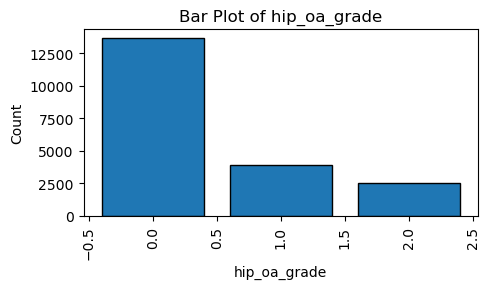

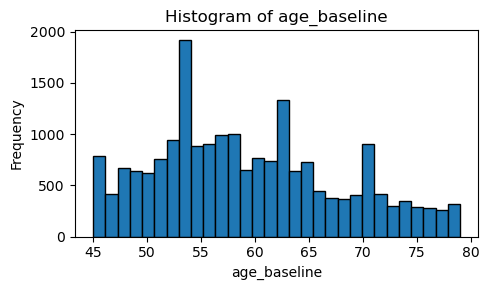

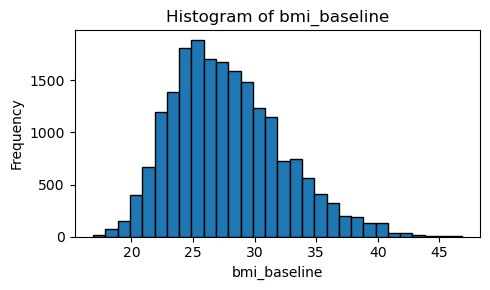

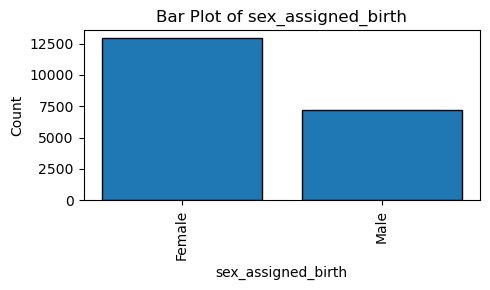

In [ ]:
def visualize_dataframe(df):
    """
    This function takes a pandas DataFrame and plots a histogram for numerical columns
    and a bar plot for categorical columns using only matplotlib.
    """
    for column in df.columns:
        plt.figure(figsize=(5, 3))

        if pd.api.types.is_numeric_dtype(df[column]):
            plt.hist(df[column].dropna(), bins=30, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {column}')

        elif pd.api.types.is_categorical_dtype(df[column]) or df[column].dtype == object:
            counts = df[column].value_counts()
            plt.bar(counts.index, counts.values, edgecolor='k')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.title(f'Bar Plot of {column}')
            plt.xticks(rotation=90)  # Rotate x-axis labels if necessary

        plt.tight_layout()
        plt.show()

df_train['hip_oa_grade'] = df_train['hip_oa_grade'].astype('category')
visualize_dataframe(df_train[['hip_oa_grade', 'age_baseline', 'bmi_baseline', 'sex_assigned_birth']])

## Load and resample a train image to a target resolution

Image size: (2590, 1501)
Input pixel spacing: [0.143, 0.143]


Text(0.5, 1.0, 'Original Image')

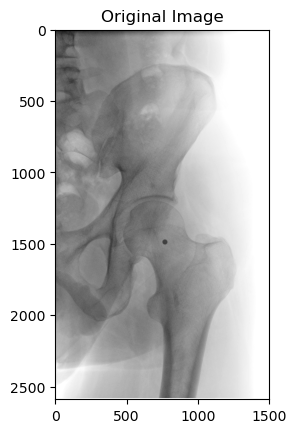

In [ ]:
#Load and plot dicom image
image_file_dicom = os.path.join(main_dir, img_folder, df_train['dicom_image'][0])
img = pydicom.dcmread(image_file_dicom)
print(f"Image size: {img.pixel_array.shape}")

# extract pixel spacing (mm/pixel) from the DICOM headers
source_pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
assert source_pixel_spacing is not None, 'no pixel spacing found'
assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'
pixel_spacing = source_pixel_spacing
print('Input pixel spacing:', source_pixel_spacing)

plt.imshow(img.pixel_array, 'gray')
plt.title('Original Image')

Scaling factor: 0.35749999999999993
Source image size: (2590, 1501)
Resized image size: (926, 537)


Text(0.5, 1.0, 'Resampled Image')

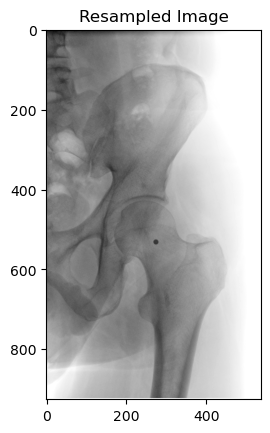

In [ ]:
# resample to the required resolution
target_pixel_spacing = 0.4 #example

scale_factor = source_pixel_spacing[0] / target_pixel_spacing
print('Scaling factor:', scale_factor)

print('Source image size:', img.pixel_array.shape)
img_pixels = skimage.transform.rescale(img.pixel_array, scale_factor)
print('Resized image size:', img_pixels.shape)

pixel_spacing = [target_pixel_spacing, target_pixel_spacing]

plt.imshow(img_pixels, 'gray')
plt.title('Resampled Image')

Photometric interpretation MONOCHROME1: inverting intensities


Text(0.5, 1.0, 'Resampled & Processed Image')

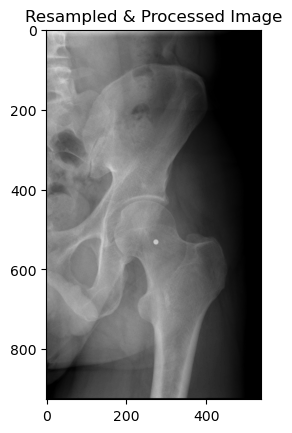

In [ ]:
#additional checks on image intensities

# are the intensities stored as MONOCHROME2 (white=max, black=min) or
# as MONOCHROME1 (white=min, black=max)?
photometric_interpretation = img.get('PhotometricInterpretation')
if photometric_interpretation == 'MONOCHROME1':
    print('Photometric interpretation MONOCHROME1: inverting intensities')
    img_pixels = np.max(img_pixels) - img_pixels
else:
    assert photometric_interpretation == 'MONOCHROME2',\
        f'{photometric_interpretation} not supported'

# other checks
assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
    'only supporting VOILUTFunction LINEAR'

plt.imshow(img_pixels, 'gray')
plt.title('Resampled & Processed Image')

In [ ]:
# Processing function
def scale_and_check_dicom_image(img, target_pixel_spacing):
    source_pixel_spacing = img.get('PixelSpacing') or img.get('ImagerPixelSpacing')
    assert source_pixel_spacing is not None, 'no pixel spacing found'
    assert source_pixel_spacing[0] == source_pixel_spacing[1], 'asymmetric pixel spacing is untested'

    scale_factor = source_pixel_spacing[0] / target_pixel_spacing
    img_pixels = skimage.transform.rescale(img.pixel_array, scale_factor)
    pixel_spacing = [target_pixel_spacing, target_pixel_spacing]

    photometric_interpretation = img.get('PhotometricInterpretation')
    if photometric_interpretation == 'MONOCHROME1':
        print('Photometric interpretation MONOCHROME1: inverting intensities')
        img_pixels = np.max(img_pixels) - img_pixels
    else:
        assert photometric_interpretation == 'MONOCHROME2',\
            f'{photometric_interpretation} not supported'

    # other checks
    assert img.get('VOILUTFunction', 'LINEAR') == 'LINEAR', \
        'only supporting VOILUTFunction LINEAR'

    return img_pixels, pixel_spacing



## Load and visualize images of 10 randomly selected train samples

Photometric interpretation MONOCHROME1: inverting intensities
Photometric interpretation MONOCHROME1: inverting intensities
Photometric interpretation MONOCHROME1: inverting intensities
Photometric interpretation MONOCHROME1: inverting intensities


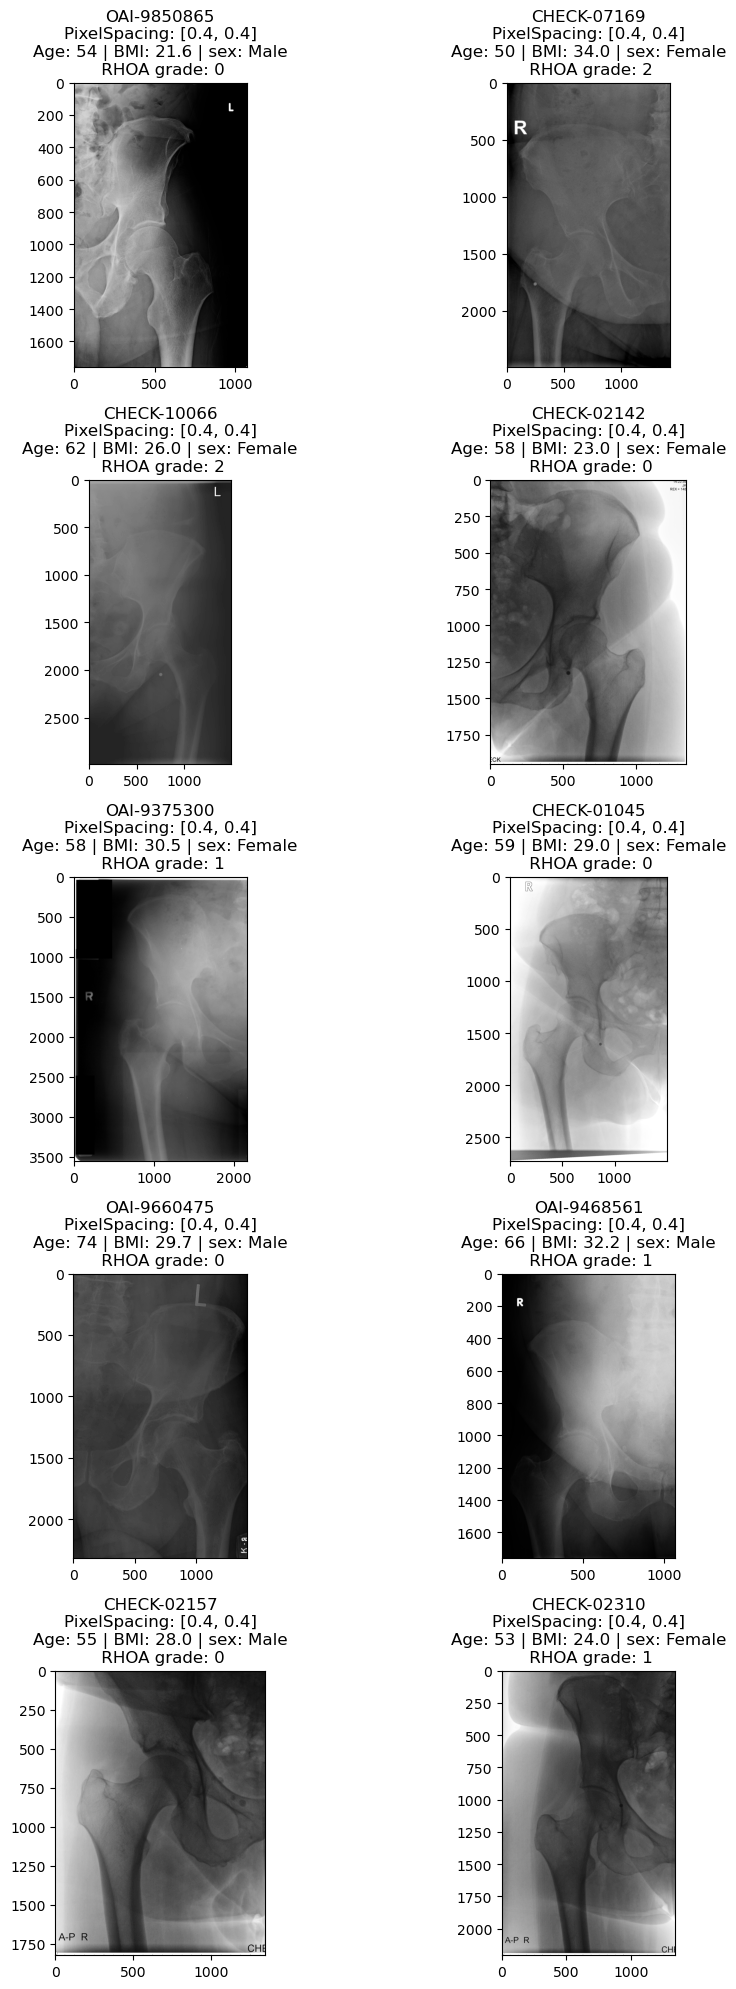

In [ ]:
#select 10 samples randomly
df_train_subset10 = df_train.sample(n=10).reset_index()

#create plot for visualisation
fig, ax = plt.subplots(5,2, figsize=(10, 20))
axes = ax.ravel()

#loop over subset of train samples

for index, row in df_train_subset10.iterrows():
    img = pydicom.dcmread(os.path.join(main_dir, img_folder, row['dicom_image']))
    img_pixels, pixel_spacing = scale_and_check_dicom_image(img, 0.4)
    axes[index].imshow(img.pixel_array, 'gray')

    axes[index].set_title(f"{row['subject_id']}\nPixelSpacing: {pixel_spacing}\nAge: {row['age_baseline']} | BMI: {row['bmi_baseline']} | sex: {row['sex_assigned_birth']}\n RHOA grade: {row['hip_oa_grade']}")
fig.tight_layout()
fig.show()